# Recommender System

## Introduction
### Objective:
Engineer a product recommendation system for our e-commerce website to find out the hot products


In [1]:
pip install psycopg2 

Note: you may need to restart the kernel to use updated packages.


In [7]:
import pandas as pd
import numpy as np
from collections import defaultdict

import psycopg2 as pg
import pandas.io.sql as pd_sql
from psycopg2 import connect
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT

from sqlalchemy import create_engine

from scipy import stats

from surprise import NormalPredictor, Reader, Dataset, accuracy, SVD, SVDpp, KNNBasic, CoClustering, SlopeOne
from surprise.model_selection import cross_validate, KFold, GridSearchCV, train_test_split


from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import math
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

In [8]:
senorita_combined = pd.read_csv(r'C:\Users\sankh\OneDrive\Desktop\ADM\Project\createddatasets\New folder\SVD1.csv',sep=';')

In [9]:
senorita_combined.columns

Index(['UserId', 'EventDate', 'EventTime', 'EventType', 'ProductID',
       'UsserSession', 'FirstName', 'LastName', 'State', 'brand_name',
       'brand_label', 'product_name', 'product_label', 'file', 'Ratings'],
      dtype='object')

In [10]:
def duplicates(data):
    """
    Prints the number of duplicates in the input dataset, removes duplicate values keeping only the 
    first entry, and returns a dataset with no duplicate values.
    """
    
    # Confirm number of duplicate rows
    print(f"There are {data.duplicated().sum()} duplicate rows.")

    # Remove any duplicates, keeping only the first entry
    data = data.drop_duplicates(keep='first')

    # Confirm duplicates were removed correctly
    print(f"After dropping, there are {data.duplicated().sum()} duplicate rows.")
    print(f"Returned dataset has {data.shape[0]} rows")
    
    return data

In [12]:
senorita_data = duplicates(senorita_combined)

There are 233 duplicate rows.
After dropping, there are 0 duplicate rows.
Returned dataset has 999767 rows


In [13]:
senorita_data.describe([.75,.99])

,UserId,ProductID,brand_label,product_label,Ratings
count,9.997670e+05,999767.000000,999767.000000,999767.000000,18826.000000
mean,5.312513e+08,1092.123385,3.072604,3.465965,4.000850
std,8.497803e+07,630.353155,1.891069,2.965613,0.815194
min,1.389897e+07,1.000000,0.000000,0.000000,3.000000
50%,5.643417e+08,1091.000000,3.000000,2.000000,4.000000
75%,5.958138e+08,1639.000000,4.000000,6.000000,5.000000
99%,5.987814e+08,2162.000000,6.000000,9.000000,5.000000
max,5.989295e+08,2184.000000,6.000000,9.000000,5.000000


In [14]:
senorita_data.head()

,UserId,EventDate,EventTime,EventType,ProductID,UsserSession,FirstName,LastName,State,brand_name,brand_label,product_name,product_label,file,Ratings
0,595414620,01-01-2020,00:00:00,view,2038,4adb70bb-edbd-4981-b60f-a05bfd32683a,Grover,Roosevelt,Florida,Yves Saint Laurent,6,handbag,2,6_2_043.png,3.0
1,595414640,01-01-2020,00:00:09,view,677,c8c5205d-be43-4f1d-aa56-4828b8151c8a,Benjamin,Pierce,Missouri,Dolce & Gabbana,2,lipstick,1,2_1_025.png,4.0
2,595412617,01-01-2020,00:00:19,view,1020,46a5010f-bd69-4fbe-a00d-bb17aa7b46f3,Calvin,Reagan,South Carolina,Gucci,3,necklace,4,3_4_004.png,3.0
3,420652863,01-01-2020,00:00:24,view,782,546f6af3-a517-4752-a98b-80c4c5860711,Richard,Cleveland,Nebraska,Dolce & Gabbana,2,necklace,4,2_4_010.png,4.0
4,484071203,01-01-2020,00:00:25,view,1268,cff70ddf-529e-4b0c-a4fc-f43a749c0acb,Andrew,Ford,Indiana,Christian Dior,4,lipstick,1,4_1_042.png,5.0


## Recommender related EDA :

## 1) Consumer centric :

In [16]:
def general_customer_info(data):
    """Returns number of unique and repeat customers in the dataset."""
    print("Number of unique customers:", data.UserId.nunique())
    
    customer_count = data.UserId.value_counts()
    print("Number of repeat customers:", customer_count[customer_count > 1].count())

    return

general_customer_info(senorita_data)

Number of unique customers: 118520
Number of repeat customers: 58576


In [17]:
# Customer locations throughout Brazil

def customer_geography(data):
    customer_locations = pd.DataFrame(data.State.value_counts().sort_values(ascending=False))
    customer_locations = customer_locations(senorita_data).reset_index().rename(columns={'index': 'State', 'State':'num_customers'})
    
    print(f"There are {customer_locations.city.nunique()} unique customer cities.\n")
    
    top_ten_cities = customer_locations.city[:10]
    customers_in_top_ten_cities = round(customer_locations.num_customers[:10].sum()/customer_locations.num_customers.sum()*100,2)

    print(f"The majority of customers, {customers_in_top_ten_cities} percent, live in the top ten cities.\n")

    return customer_locations, top_ten_cities

In [18]:
senorita_data.columns

Index(['UserId', 'EventDate', 'EventTime', 'EventType', 'ProductID',
       'UsserSession', 'FirstName', 'LastName', 'State', 'brand_name',
       'brand_label', 'product_name', 'product_label', 'file', 'Ratings'],
      dtype='object')

In [19]:
customer_locations = pd.DataFrame(senorita_data.State.value_counts().sort_values(ascending=False))

In [20]:
customer_locations = customer_locations.reset_index().rename(columns={'index': 'State', 'State':'num_customers'})

In [21]:
customer_locations

,State,num_customers
0,New York,24467
1,Missouri,23322
2,Minnesota,22993
3,Tennessee,22929
4,Nevada,22643
5,Maryland,22599
6,Hawaii,22507
7,Connecticut,22299
8,Delaware,22270
9,South Dakota,22142


In [22]:
top_ten_cities = customer_locations.State[:10]

In [23]:
customers_in_top_ten_cities = round(customer_locations.num_customers[:10].sum()/customer_locations.num_customers.sum()*100,2)
print(f"The majority of customers, {customers_in_top_ten_cities} percent, live in the top ten cities.\n")

The majority of customers, 22.82 percent, live in the top ten cities.



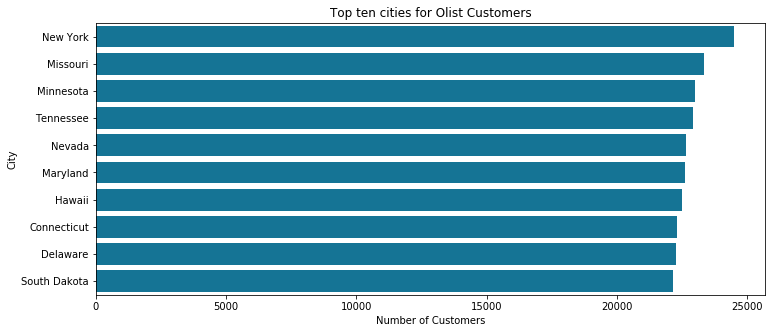

In [24]:
# plot top cities
fig = plt.figure(figsize=(12,5))
ax = fig.gca()
sns.barplot(x=customer_locations.num_customers[:10], y=top_ten_cities, ax=ax, color=senorita_blue)
ax.set(xlabel='Number of Customers', ylabel='City', title='Top ten cities for senorita Customers');

## Feature Engineering

When entering the site, the customers are flagged as a repeat customer or new customer and handled as follows.

**Repeat Customers:** Collaborative filtering is used to recommend products. Results are measured by how many predictions are right using the recommender vs. how many are right when just recommending the most popular item.

**For New Users:** Recommendation based on

Customer Segmentation, then pick the top product in that customer base <br>
People in your area, then pick the top products in that customer base <br>
Results are measured by comparing predictions to the overall most popular item <br>

In [25]:
def repeat_and_first_time(data):
    """Takes in a dataset and returns back the dataset with only repeated customers"""
    repeaters = data.groupby('UserId').filter(lambda x: len(x) > 1)
    first_timers = data.groupby('UserId').filter(lambda x: len(x) == 1)
    
    # Save datasets for easier accessing
    repeater_data.to_csv('repeater_data.csv')
    first_timer_data.to_csv('first_timer_data.csv')
    
    print("Shape of repeater dataset:", repeater_data.shape)

    print("Shape of first timer dataset:", first_timer_data.shape)

    return repeaters, first_timers

In [26]:
repeater_data =  senorita_data.groupby('UserId').filter(lambda x: len(x) > 1)

In [27]:
first_timers = senorita_data.groupby('UserId').filter(lambda x: len(x) == 1)

In [28]:
repeater_data.to_csv('repeater_data.csv')
first_timers.to_csv('first_timer_data.csv')

In [29]:
repeater_data.head()

,UserId,EventDate,EventTime,EventType,ProductID,UsserSession,FirstName,LastName,State,brand_name,brand_label,product_name,product_label,file,Ratings
2,595412617,01-01-2020,00:00:19,view,1020,46a5010f-bd69-4fbe-a00d-bb17aa7b46f3,Calvin,Reagan,South Carolina,Gucci,3,necklace,4,3_4_004.png,3.0
3,420652863,01-01-2020,00:00:24,view,782,546f6af3-a517-4752-a98b-80c4c5860711,Richard,Cleveland,Nebraska,Dolce & Gabbana,2,necklace,4,2_4_010.png,4.0
5,595412617,01-01-2020,00:00:30,view,1799,46a5010f-bd69-4fbe-a00d-bb17aa7b46f3,Calvin,Reagan,South Carolina,Versace,5,necklace,4,5_4_014.png,3.0
6,593016733,01-01-2020,00:00:37,cart,1726,848f607c-1d14-474a-8869-c40e60783c9d,Andrew,Madison,California,Versace,5,handbag,2,5_2_017.png,4.0
7,595411904,01-01-2020,00:00:46,view,1110,74ca1cd5-5381-4ffe-b00b-a258b390db77,Harry,Kennedy,Nebraska,Gucci,3,ring,6,3_6_046.png,3.0


In [30]:
first_timers.head()

,UserId,EventDate,EventTime,EventType,ProductID,UsserSession,FirstName,LastName,State,brand_name,brand_label,product_name,product_label,file,Ratings
0,595414620,01-01-2020,00:00:00,view,2038,4adb70bb-edbd-4981-b60f-a05bfd32683a,Grover,Roosevelt,Florida,Yves Saint Laurent,6,handbag,2,6_2_043.png,3.0
1,595414640,01-01-2020,00:00:09,view,677,c8c5205d-be43-4f1d-aa56-4828b8151c8a,Benjamin,Pierce,Missouri,Dolce & Gabbana,2,lipstick,1,2_1_025.png,4.0
4,484071203,01-01-2020,00:00:25,view,1268,cff70ddf-529e-4b0c-a4fc-f43a749c0acb,Andrew,Ford,Indiana,Christian Dior,4,lipstick,1,4_1_042.png,5.0
14,539775844,01-01-2020,00:01:31,view,687,e04ed824-4857-40e4-a783-aca4001bc05b,Ronald,Carter,Delaware,Dolce & Gabbana,2,lipstick,1,2_1_035.png,5.0
21,579707372,01-01-2020,00:01:45,view,1186,c4e35119-bbf5-49fa-9043-61cb7583c250,Franklin,Reagan,Arizona,Christian Dior,4,shoes,0,4_0_005.png,4.0


In [31]:
def regenerate_dataset_with_indicators(repeater_data, first_timers):
    repeater_data['repeater'] = 1
    first_timers['repeater'] = 0
    
    full_df = pd.concat((repeater_data, first_timers), axis=0).reset_index()
    print("full_df shape:", full_df.shape)
    return full_df

In [32]:
full_df = regenerate_dataset_with_indicators(repeater_data, first_timers)

full_df shape: (999767, 17)


In [33]:
full_df

,index,UserId,EventDate,EventTime,EventType,ProductID,UsserSession,FirstName,LastName,State,brand_name,brand_label,product_name,product_label,file,Ratings,repeater
0,2,595412617,01-01-2020,00:00:19,view,1020,46a5010f-bd69-4fbe-a00d-bb17aa7b46f3,Calvin,Reagan,South Carolina,Gucci,3,necklace,4,3_4_004.png,3.0,1
1,3,420652863,01-01-2020,00:00:24,view,782,546f6af3-a517-4752-a98b-80c4c5860711,Richard,Cleveland,Nebraska,Dolce & Gabbana,2,necklace,4,2_4_010.png,4.0,1
2,5,595412617,01-01-2020,00:00:30,view,1799,46a5010f-bd69-4fbe-a00d-bb17aa7b46f3,Calvin,Reagan,South Carolina,Versace,5,necklace,4,5_4_014.png,3.0,1
3,6,593016733,01-01-2020,00:00:37,cart,1726,848f607c-1d14-474a-8869-c40e60783c9d,Andrew,Madison,California,Versace,5,handbag,2,5_2_017.png,4.0,1
4,7,595411904,01-01-2020,00:00:46,view,1110,74ca1cd5-5381-4ffe-b00b-a258b390db77,Harry,Kennedy,Nebraska,Gucci,3,ring,6,3_6_046.png,3.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999762,999962,598929457,09-01-2020,17:16:46,view,1154,1e7d83d8-fe90-4826-b150-2919faccab02,Bill,Roosevelt,Vermont,Gucci,3,boots,8,3_8_013.png,NaN,0
999763,999973,598929475,09-01-2020,17:16:50,view,147,46db5a36-d141-4340-a113-c5f7d2084f65,James,Carter,Wisconsin,Christian Louboutin,0,handbag,2,0_2_005.png,NaN,0
999764,999984,228729308,09-01-2020,17:16:55,cart,550,b1438f1a-dc23-49f7-ac0d-7510cf412f56,Dwight,Clinton,Illinois,Chanel,1,boots,8,1_8_031.png,NaN,0
999765,999986,412278522,09-01-2020,17:16:56,view,986,ea484af1-85b1-4314-81fd-bcf5194d1488,John,Roosevelt,New Jersey,Gucci,3,handbag,2,3_2_047.png,NaN,0


# First Time Users

In [34]:
def find_popular_items(data, n_recs):
    top_n_items = data.brand_name.value_counts().sort_values(ascending=False)[:n_recs].index
    return list(top_n_items)

In [35]:
def find_popular_product(data, n_recs):
    top_n_items = data.product_name.value_counts().sort_values(ascending=False)[:n_recs].index
    return list(top_n_items)

In [36]:
def popular_in_your_area(data, state, n_recs):
    location_df = data[data.State == state]
    top_n_items = location_df.brand_name.value_counts().sort_values(ascending=False)[:n_recs].index
    return list(top_n_items)

In [37]:
def first_time_recommender(data, uid, n_recs):
    hot_items = find_popular_items(data, n_recs)
    #state = data[data.UserId==uid].State.max()
    hot_product = find_popular_product(data, n_recs)
    #popular_in_area = find_popular_product(data, state, n_recs)
   # print(f"State{state}\n")
    print(f"Hot Brands you might like:\n {hot_items}\n")
    print(f"Popular Categories in your area:\n {hot_product}")
    
    recommendation = {'Hot Items': hot_items, 'Area': hot_product}
    
    return recommendation

In [40]:
# Example Recommendation
recommendation = first_time_recommender(full_df, '245642504', 4)

Hot Brands you might like:
 ['Christian Dior', 'Chanel', 'Gucci', 'Yves Saint Laurent']

Popular Categories in your area:
 ['shoes', 'handbag', 'lipstick', 'ring']


In [177]:
full_df[full_df.UserId=='595412617'].State

Series([], Name: State, dtype: object)

In [146]:
full_df

,index,UserId,EventDate,EventTime,EventType,ProductID,UsserSession,FirstName,LastName,State,brand_name,brand_label,product_name,product_label,file,Ratings,repeater
0,2,595412617,01-01-2020,00:00:19,view,1020,46a5010f-bd69-4fbe-a00d-bb17aa7b46f3,Calvin,Reagan,South Carolina,Gucci,3,necklace,4,3_4_004.png,3.0,1
1,3,420652863,01-01-2020,00:00:24,view,782,546f6af3-a517-4752-a98b-80c4c5860711,Richard,Cleveland,Nebraska,Dolce & Gabbana,2,necklace,4,2_4_010.png,4.0,1
2,5,595412617,01-01-2020,00:00:30,view,1799,46a5010f-bd69-4fbe-a00d-bb17aa7b46f3,Calvin,Reagan,South Carolina,Versace,5,necklace,4,5_4_014.png,3.0,1
3,6,593016733,01-01-2020,00:00:37,cart,1726,848f607c-1d14-474a-8869-c40e60783c9d,Andrew,Madison,California,Versace,5,handbag,2,5_2_017.png,4.0,1
4,7,595411904,01-01-2020,00:00:46,view,1110,74ca1cd5-5381-4ffe-b00b-a258b390db77,Harry,Kennedy,Nebraska,Gucci,3,ring,6,3_6_046.png,3.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999762,999962,598929457,09-01-2020,17:16:46,view,1154,1e7d83d8-fe90-4826-b150-2919faccab02,Bill,Roosevelt,Vermont,Gucci,3,boots,8,3_8_013.png,NaN,0
999763,999973,598929475,09-01-2020,17:16:50,view,147,46db5a36-d141-4340-a113-c5f7d2084f65,James,Carter,Wisconsin,Christian Louboutin,0,handbag,2,0_2_005.png,NaN,0
999764,999984,228729308,09-01-2020,17:16:55,cart,550,b1438f1a-dc23-49f7-ac0d-7510cf412f56,Dwight,Clinton,Illinois,Chanel,1,boots,8,1_8_031.png,NaN,0
999765,999986,412278522,09-01-2020,17:16:56,view,986,ea484af1-85b1-4314-81fd-bcf5194d1488,John,Roosevelt,New Jersey,Gucci,3,handbag,2,3_2_047.png,NaN,0
